## CSCI S-89C Deep Reinforcement Learning, Summer 2020
### Section 11

## Model Validation

We consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" (denoted by 0) and "transplant" (denoted by 1). 

We assume that the Markov property holds. There are two additional states of the Markov Decision Process: "Posttransplant Life" (denoted by 19) and "Death" (which is denoted by 20 and combines so caled "Pretransplant Death" and "Posttransplant Death"). The only action availible in state "Posttransplant Life" is "wait" and "Death" is the terminal state with no actions. Assume that the length of an episode is T=50, unless it terminates earlier due to the transition to the absorbing state "Death."

We do not know the transition probabilities, but if a patient selects "wait," the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Death    
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Death    

If a patient selects "transplant" at Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there are two more possible transitions"  
5) "Posttransplant Life"->"Posttransplant Life" and "Posttransplant Life"->"Death"  


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state - assume that the patient gets these rewards on "exit" from the states, i.e. after we observe the corresponding stage. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


Please consider statistics on 8,000 patients with ESLD saved in the 'ESLD_statistics.csv' file. Eeach row represents an episode (i.e. one patient) and the columns are the sequences of the patients' states and actions. This data were generated under the following policy:

$\pi(1|k)=0.02$ for $k\in\{1,2,3,4,5,6,7,8,9,10,11,12,13\}$;   
$\pi(1|14)=0.05$;   
$\pi(1|15)=0.10$;   
$\pi(1|16)=0.20$;   
$\pi(1|17)=0.40$;  
$\pi(1|18)=0.60$;  

which means that, for example, 5% of paients at stage 14 received a transplant.
    

Let's denote the state-value obtained in (at most) 50 time steps by $v_\pi(s)$, i.e. $T=50$.

### (a) Splitting into train and test sets
We first break the dataset randomly into train (80%) and test (20%) sets. The train set should have 6,400 patients.

In [1]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/ESLD_statistics.csv')
df.head(5)

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
0,12,0,12,0,13,0,13,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1,3,0,3,0,3,0,3,0,3,0,...,0,20,0,20,0,20,0,20,0,20
2,16,0,16,0,16,1,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20
3,13,0,13,0,13,0,13,0,14,0,...,0,20,0,20,0,20,0,20,0,20
4,4,0,4,0,4,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20


In [3]:
def get_episode(df, k):
    states = df.values[k,0:-1:2]
    actions = df.values[k,1::2]
    rewards = (states <= 18)*1 + (states == 19)*0.2
    return [states, actions, rewards]

In [4]:
get_episode(df, 2)

[array([16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
       dtype=int64),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64),
 array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])]

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 2)

print("Train set df_train:", df_train.shape)
print("Test set df_test:", df_test.shape)

Train set df_train: (6400, 101)
Test set df_test: (1600, 101)


### (b) Quadratic approximation
Using the train data, we approximate the state-values via the semi-gradient 1-step TD algorithm (with experience replay) for estimating $v_\pi$ with

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2\, \frac{k-9}{5}+w_3\, \left(\frac{k-9}{5}\right)^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})}.$$

In [6]:
def v_hat2(k, w):
    v = (w[0] + w[1]*(k-9)/5 + w[2]*((k-9)/5)**2)*(k<=18) + w[3]*(k==19)
    return v

def dv_hat2(k, w):
    dv = [1, (k-9)/5, ((k-9)/5)**2, 0]*int(k<=18) + [0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0]*int(k==20)
    return np.array(dv)

In [7]:
np.random.seed(3455)

alpha = 0.2
gamma = 0.97
T = 50
num_episodes = df_train.shape[0]
num_epochs = 500000
w2 = np.zeros(4)
w2_history = w2.reshape((4,1))
N = 0

for i in range(num_epochs):
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    w2 = w2 + alpha/np.sqrt(N)*(R + gamma*v_hat2(S1,w2)*(N%T!=(T-1)) - v_hat2(S,w2))*dv_hat2(S,w2)
    if (int(N/1000)*1000==N):
        w2_history = np.append(w2_history, w2.reshape((4,1)), axis=1)

In [8]:
w2

array([ 3.91631687, -2.24830941,  1.09707393,  1.31172815])

In [9]:
V2_hat = [v_hat2(k,w2) for k in range(1,21)]
V2_hat

[10.322121191710167,
 9.21421495064176,
 8.194074624006348,
 7.261700211803929,
 6.417091714034506,
 5.6602491306980784,
 4.991172461794644,
 4.409861707324206,
 3.9163168672867625,
 3.510537941682314,
 3.1925249305108605,
 2.9622778337724007,
 2.819796651466937,
 2.7650813835944676,
 2.798132030154993,
 2.9189485911485136,
 3.1275310665750298,
 3.42387945643454,
 1.3117281500869606,
 0.0]

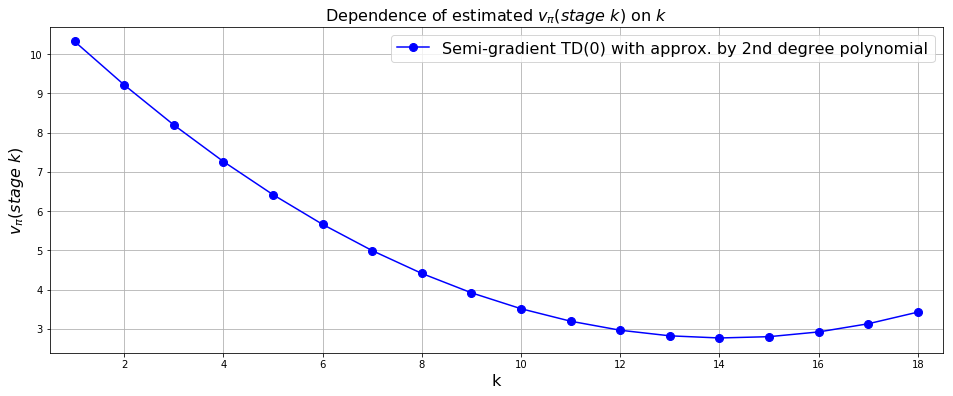

In [10]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V2_hat[0:18], linestyle='-', marker="o",color = "b", markersize=8, label='Semi-gradient TD(0) with approx. by 2nd degree polynomial')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

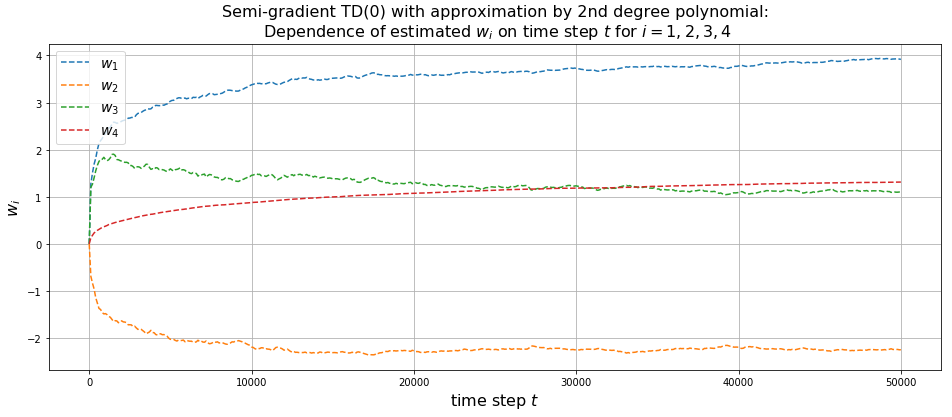

In [11]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w2_history.shape[1]*100,100),w2_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w2_history.shape[1]*100,100),w2_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w2_history.shape[1]*100,100),w2_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w2_history.shape[1]*100,100),w2_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0) with approximation by 2nd degree polynomial:\n Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

### (c) 3rd degree polynomial approximation
Using the train data, we approximate the state-values via the semi-gradient 1-step TD algorithm (with experience replay) for estimating $v_\pi$ with

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2\, \frac{k-9}{5}+w_3\, \left(\frac{k-9}{5}\right)^2+w_4\, \left(\frac{k-9}{5}\right)^3\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_5\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})}.$$

In [12]:
def v_hat3(k, w):
    v = (w[0] + w[1]*(k-9)/5 + w[2]*((k-9)/5)**2 + w[3]*((k-9)/5)**3)*(k<=18) + w[4]*(k==19)
    return v

def dv_hat3(k, w):
    dv = [1, (k-9)/5, ((k-9)/5)**2, ((k-9)/5)**3, 0]*int(k<=18) + [0, 0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0, 0]*int(k==20)
    return np.array(dv)

In [13]:
np.random.seed(3455)

alpha = 0.2
gamma = 0.97
T = 50
num_episodes = df_train.shape[0]
num_epochs = 500000
w3 = np.zeros(5)
w3_history = w3.reshape((5,1))
N = 0

for i in range(num_epochs):
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    w3 = w3 + alpha/np.sqrt(N)*(R + gamma*v_hat3(S1,w3)*(N%T!=(T-1)) - v_hat3(S,w3))*dv_hat3(S,w3)
    if (int(N/1000)*1000==N):
        w3_history = np.append(w3_history, w3.reshape((5,1)), axis=1)

In [14]:
w3

array([ 3.99127789, -1.14006177,  1.02012389, -0.60736797,  1.31172815])

In [15]:
V3_hat = [v_hat3(k,w3) for k in range(1,21)]
V3_hat

[10.914673089162322,
 9.253424905612647,
 7.87786227116583,
 6.758831523309847,
 5.867178999532678,
 5.173751037322303,
 4.649393974166703,
 4.2649541475538575,
 3.9912778949717467,
 3.799211553908351,
 3.6596014618516484,
 3.543293956289621,
 3.4211353747102486,
 3.2639720546015103,
 3.042650333451387,
 2.7280165487478576,
 2.2909170379789026,
 1.7021981386325011,
 1.3117281500869606,
 0.0]

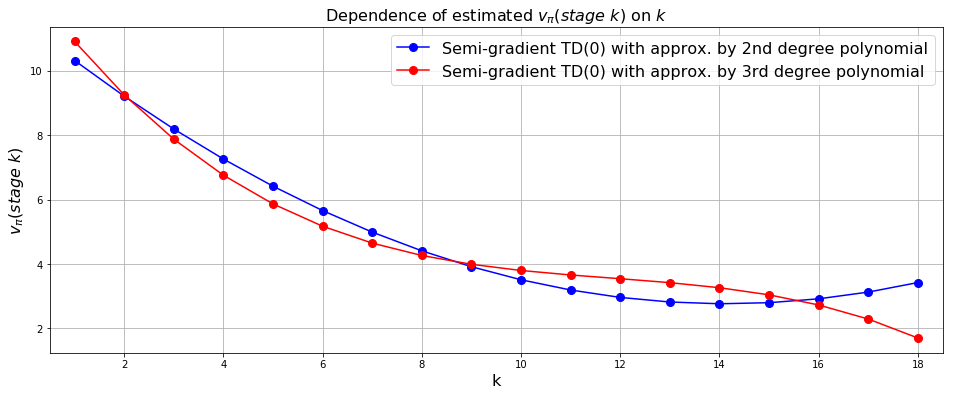

In [16]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V2_hat[0:18], linestyle='-', marker="o",color = "b", markersize=8, label='Semi-gradient TD(0) with approx. by 2nd degree polynomial')
plt.plot(range(1,19),V3_hat[0:18], linestyle='-', marker="o",color = "r", markersize=8, label='Semi-gradient TD(0) with approx. by 3rd degree polynomial')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

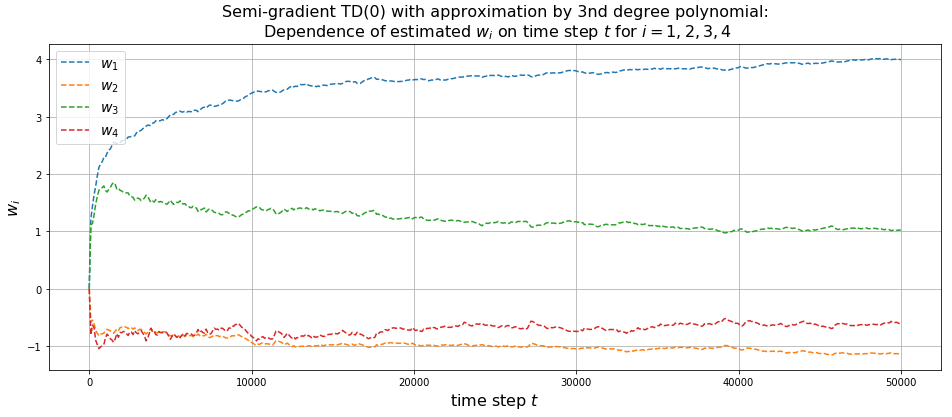

In [17]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w3_history.shape[1]*100,100),w3_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w3_history.shape[1]*100,100),w3_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w3_history.shape[1]*100,100),w3_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w3_history.shape[1]*100,100),w3_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('Semi-gradient TD(0) with approximation by 3nd degree polynomial:\n Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

### (d) Validation plot
Using test data, we compute observed returns (cumulative discounted rewards) $G_0$ obtained under policy $\pi$. These returns will be used for validation. We notice that that the results for the state-value function obtained in (b) and (c) also correspond to $T=50$ (not $T=\infty$). Notice that we have 1,600 retunrs only (in fact, one could also consider $G_1$, $G_2$, etc.).

In [18]:
gamma = 0.97
T = 50
n_episodes = df_test.shape[0]
G0 = [None] * n_episodes

for k in range(n_episodes):
        episode = get_episode(df_test, k)
        G = 0
        W = 1.0
        for t in reversed(range(0,T)):
            S = episode[0][t]
            A = episode[1][t]
            R = episode[2][t]
            G = gamma*G + R
        G0[k] = G

In [19]:
len(G0)

1600

In [20]:
df_test.head(4)

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
6315,12,0,20,0,20,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1457,12,0,12,0,13,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20
7778,9,0,9,0,9,0,9,0,9,0,...,0,20,0,20,0,20,0,20,0,20
5623,16,1,19,0,19,0,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20


In [21]:
S0 = df_test.iloc[:,0]
S0[:4]

6315    12
1457    12
7778     9
5623    16
Name: S0, dtype: int64

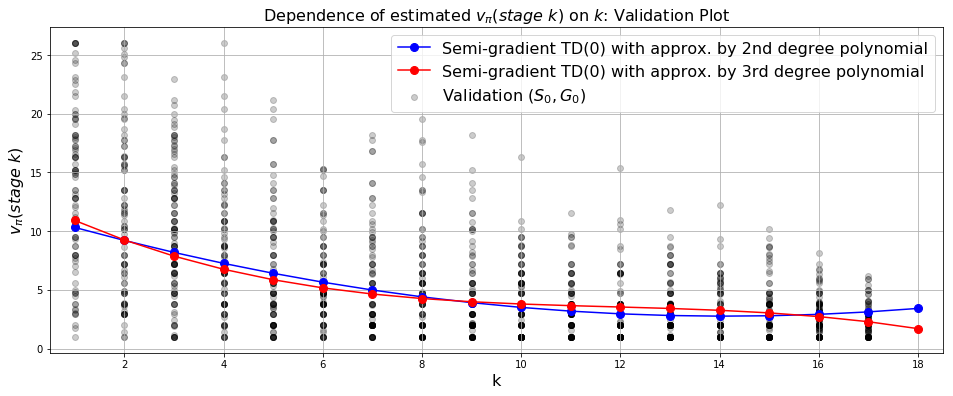

In [22]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V2_hat[0:18], linestyle='-', marker="o",color = "b", markersize=8, label='Semi-gradient TD(0) with approx. by 2nd degree polynomial')
plt.plot(range(1,19),V3_hat[0:18], linestyle='-', marker="o",color = "r", markersize=8, label='Semi-gradient TD(0) with approx. by 3rd degree polynomial')
plt.scatter(S0,G0,label="Validation $(S_0,G_0)$", color="k", alpha=.2)
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$: Validation Plot',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

### (e) Mean squared errors
Here, we compute the mean squared error as follows

$$MSE = \frac{1}{1600}\sum_{i=1}^{1600} \left(G_0^i-\hat{v}(S_0^i,{\bf w})\right)^2.$$

In [23]:
MSE2 = np.mean((v_hat2(S0,w2) - G0)**2)
MSE2

17.905118479178835

In [24]:
MSE3 = np.mean((v_hat3(S0,w3) - G0)**2)
MSE3

17.903949793856224